In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset = pd.read_csv("UberDataset.csv")
dataset.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [4]:
dataset.shape

(1156, 7)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


Data Preprocessing

In [6]:
dataset['PURPOSE'].fillna("NOT", inplace=True)

<ipython-input-6-eb49c4d16340>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['PURPOSE'].fillna("NOT", inplace=True)


START_DATE, END_DATE are in inconsistent format so we need to change it to common pd.datetime format.

In [7]:
dataset['START_DATE'] = pd.to_datetime(dataset['START_DATE'], errors='coerce')
dataset['END_DATE'] = pd.to_datetime(dataset['END_DATE'], errors='coerce')


In [8]:
from datetime import datetime

dataset['date'] = pd.DatetimeIndex(dataset['START_DATE']).date  #separating date
dataset['time'] = pd.DatetimeIndex(dataset['START_DATE']).hour  #separating time

# separate time into 4 shifts for better understanding
dataset['day-night'] = pd.cut(x=dataset['time'],
                               bins=[0,10,15,19,25],
                               labels = ['Morning','Afternoon','Evening','Night'])

In [9]:
print(dataset.shape)
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)
print(dataset.shape)

(1156, 10)
(413, 10)


Null rows and duplicate rows are removed.

---

Data Visualization

In [10]:
# We'll find unique values of each categorical column
obj = (dataset.dtypes == 'object')
obj_col = list(obj[obj].index)

unique_values = {}
for col in obj_col:
  unique_values[col] = dataset[col].unique().size
unique_values

{'CATEGORY': 2, 'START': 108, 'STOP': 112, 'PURPOSE': 7, 'date': 113}

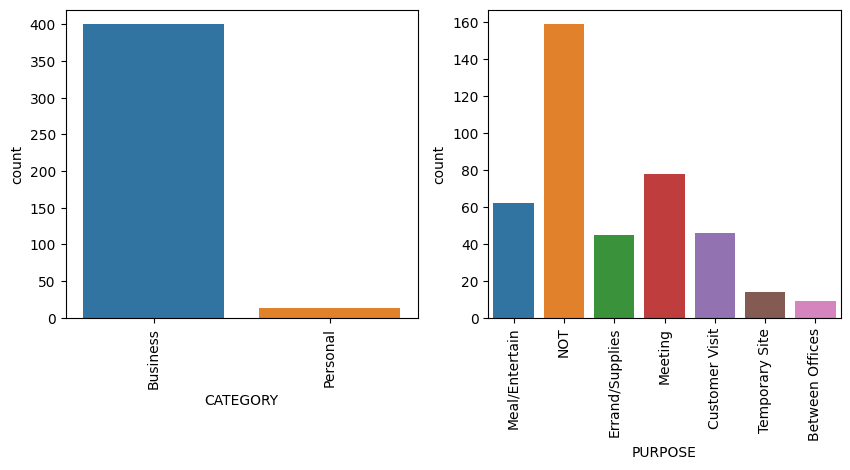

In [11]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.countplot(x=dataset['CATEGORY'], hue=dataset['CATEGORY'])
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.countplot(x=dataset['PURPOSE'], hue=dataset['PURPOSE'])
plt.xticks(rotation=90)

plt.show()

We infer that The cabs are mostly booked for Business use and rearely ever booked for Personal use by the people.

Purpose of booking cab is mostly unknown as shown in the figure apart from that it is mainly getting booked for Meetings and Meal/Entertainment

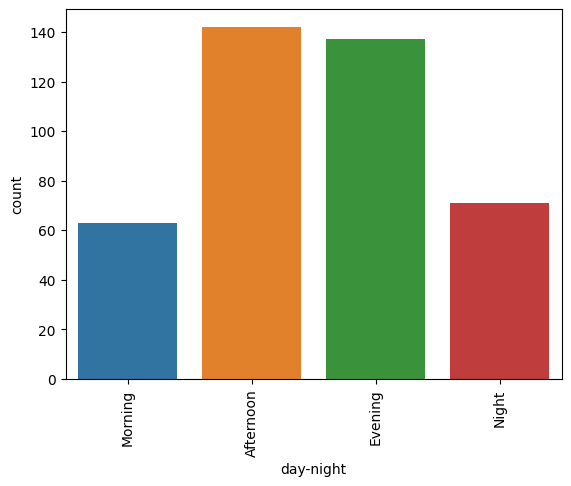

In [12]:
sns.countplot(x=dataset['day-night'],hue=dataset['day-night'])
plt.xticks(rotation=90)
plt.show()

We infer that the rides are getting booked during Afternoon(10AM to 3PM) and Evening(3PM to 7PM) more than other times.

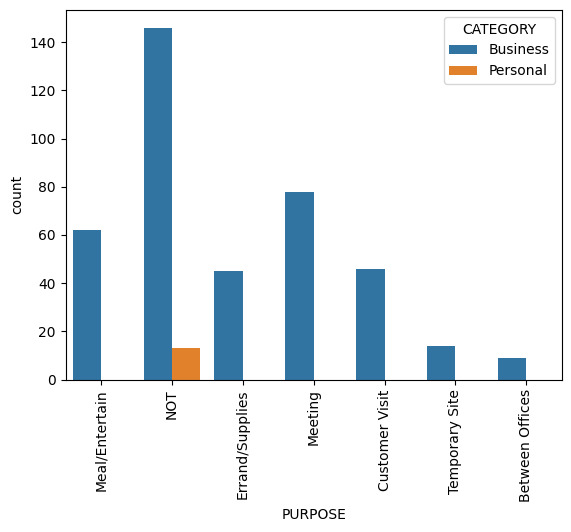

In [13]:
sns.countplot(data=dataset, x='PURPOSE', hue='CATEGORY')
plt.xticks(rotation=90)
plt.show()

We infer thath rides getting booked for personal usage is extremely less and the we don't even know the purpose of those little booking since it's unknown.

In [14]:
from sklearn.preprocessing import OneHotEncoder

obj_cols = ['CATEGORY',"PURPOSE"]
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(dataset[obj_cols]))
OH_cols.index = dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = dataset.drop(obj_cols, axis=1)
dataset = pd.concat([df_final, OH_cols], axis=1)
dataset

,START_DATE,END_DATE,START,STOP,MILES,date,time,day-night,CATEGORY_Business,CATEGORY_Personal,PURPOSE_Between Offices,PURPOSE_Customer Visit,PURPOSE_Errand/Supplies,PURPOSE_Meal/Entertain,PURPOSE_Meeting,PURPOSE_NOT,PURPOSE_Temporary Site
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Fort Pierce,Fort Pierce,5.1,2016-01-01,21.0,Night,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2016-01-02 01:25:00,2016-01-02 01:37:00,Fort Pierce,Fort Pierce,5.0,2016-01-02,1.0,Morning,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Fort Pierce,Fort Pierce,4.8,2016-01-02,20.0,Night,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Fort Pierce,Fort Pierce,4.7,2016-01-05,17.0,Evening,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Fort Pierce,West Palm Beach,63.7,2016-01-06,14.0,Afternoon,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,2016-12-12 13:22:00,2016-12-12 13:32:00,Cary,Cary,3.1,2016-12-12,13.0,Afternoon,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1044,2016-12-12 13:36:00,2016-12-12 13:51:00,Cary,Apex,4.4,2016-12-12,13.0,Afternoon,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1045,2016-12-12 14:26:00,2016-12-12 14:39:00,Apex,Cary,4.7,2016-12-12,14.0,Afternoon,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1046,2016-12-12 17:51:00,2016-12-12 18:01:00,Cary,Morrisville,3.0,2016-12-12,17.0,Evening,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<Axes: >

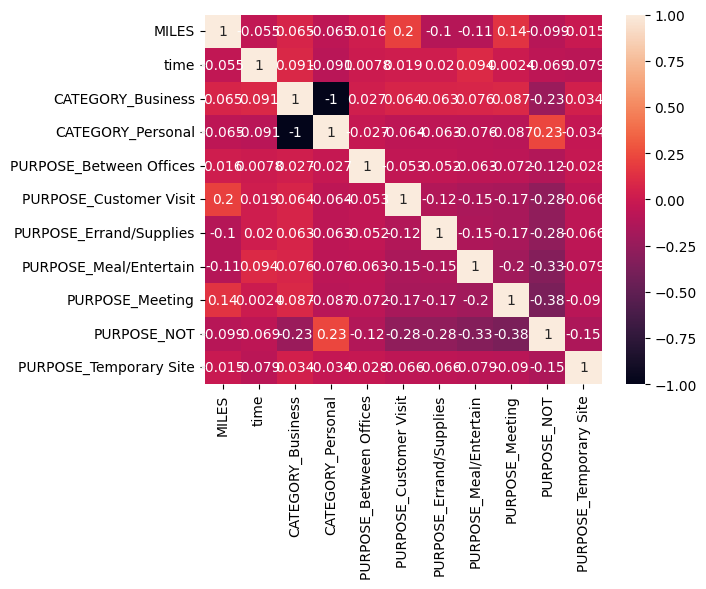

In [15]:
sns.heatmap(dataset.corr(numeric_only=True), annot=True)

We can see there is high negative corelation between Personal and Business Category.

There is not much corelation between other features.

[Text(0.5, 0, 'MONTH'), Text(0, 0.5, 'VALUE COUNT')]

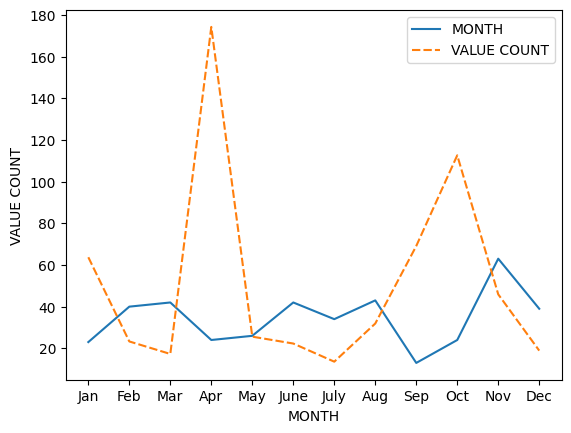

In [17]:
dataset['MONTH'] = pd.DatetimeIndex(dataset['START_DATE']).month
month_label = {1.0:"Jan",2.0:"Feb",3.0:"Mar",4.0:"Apr",
               5.0:"May",6.0:"June",7.0:"July",8.0:"Aug",
               9.0:"Sep",10.0:"Oct",11.0:"Nov",12.0:"Dec",}

dataset['MONTH'] = dataset.MONTH.map(month_label)
mon = dataset.MONTH.value_counts(sort=False)

df = pd.DataFrame({"MONTH":mon.values,"VALUE COUNT":dataset.groupby('MONTH',sort=False)['MILES'].max()})

p = sns.lineplot(data=df)
p.set(xlabel = "MONTH", ylabel="VALUE COUNT")

The above plot says that the ride demands are low in the month of nov, dec, jan probably because of the winter.

In [21]:
dataset['Day'] = dataset.START_DATE.dt.weekday
day_label = {
    0:'Mon',1:'Tues',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'
}
dataset['Day'] = dataset['Day'].map(day_label)

Text(0, 0.5, 'COUNT')

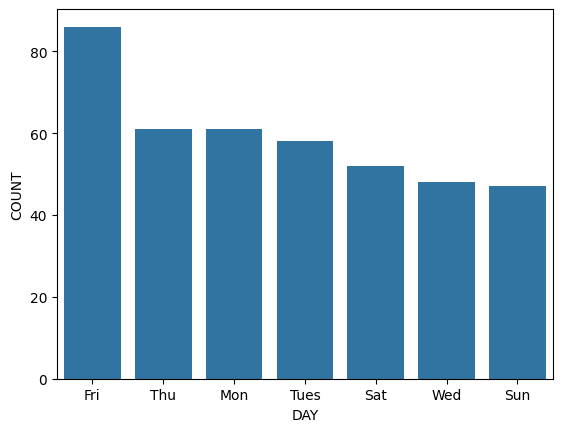

In [22]:
day_label = dataset['Day'].value_counts()
sns.barplot(x=day_label.index, y=day_label)
plt.xlabel("DAY")
plt.ylabel('COUNT')

We infer that Friday is the day hen most of the rides are done.

Now let's explore Miles column.


<Axes: ylabel='MILES'>

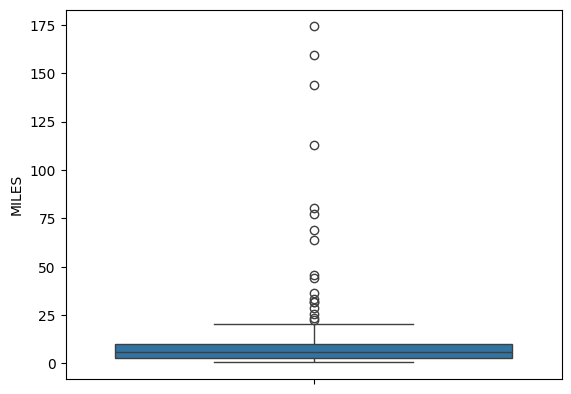

In [23]:
sns.boxplot(dataset['MILES'])

<Axes: ylabel='MILES'>

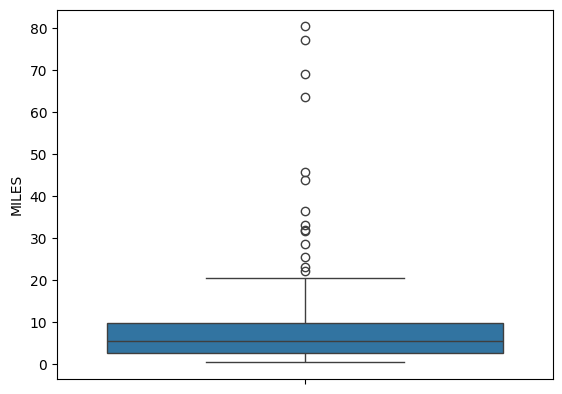

In [24]:
sns.boxplot(dataset[dataset['MILES']<100]['MILES'])

<Axes: xlabel='MILES', ylabel='Count'>

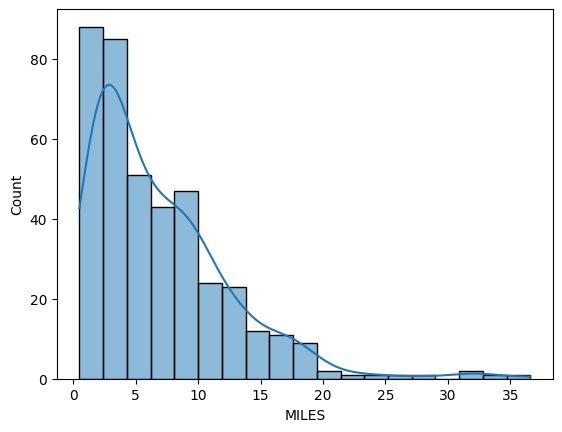

In [26]:
sns.histplot(dataset[dataset['MILES']<40]['MILES'], kde=True)

We infer that most of the rides booked are for less than 5 miles and majority of people chose cabs for less than 20 miles.

Thank you so much for going through my work will the end, feel free to get in touch if you have any doubts.. :)